In [1]:
import os

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_YOLO_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)


/home/yeli/yeli/data/lard
/home/yeli/Nextcloud/lard/yolov8


# 结果可视化

In [2]:
import json
import cv2
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random

CONFIDENCE_THRESHOLD = 0.35

# 文件定义
ground_truth_path = f'{ROOT_DATA}/annotations/instances_test_real_nominal.json'
predictions_path = f'{ROOT_PROJECT}/runs/detect/yolov8n_train_val/val_test_real_nominal/predictions_modified.json'

# 加载预测的 JSON 文件
with open(predictions_path, 'r') as f:
    predictions = json.load(f)

# 初始化 COCO 对象（用于标签）
coco = COCO(ground_truth_path)
catIds = coco.getCatIds()
categories = coco.loadCats(catIds)

# 获取全部图像ID
imgIds = coco.getImgIds()

selected_imgIds = random.sample(imgIds, 1)
selected_imgIds = [1318]


loading annotations into memory...
Done (t=2.05s)
creating index...
index created!


In [3]:
img_dict = coco.loadImgs(selected_imgIds)[0]

# 读取图像
image_path = f'{ROOT_DATA}/YoloFormat/test_real_nominal/images/{img_dict["file_name"]}'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 获取GT
annIds = coco.getAnnIds(imgIds=img_dict['id'])  # 依据图像id查找gt的id
anns = coco.loadAnns(annIds)  # 依据gt的id加载gt

# 获取Pred
preds = [
    pred for pred in predictions
    if pred['image_id'] == img_dict['id']
    and pred['score'] >= CONFIDENCE_THRESHOLD
]

# 类别字典
id_2_name = {0: 'runway'}

print(id_2_name)
print(anns)
print(preds)


{0: 'runway'}
[{'id': 1318, 'image_id': 1318, 'category_id': 0, 'bbox': [1179.9999999999998, 879.0, 1453.0, 525.0], 'area': 762825.0, 'iscrowd': 0}]
[{'image_id': 1318, 'category_id': 0, 'bbox': [1342.542, 883.607, 1157.227, 538.153], 'score': 0.90489}]


# 随机获取图像

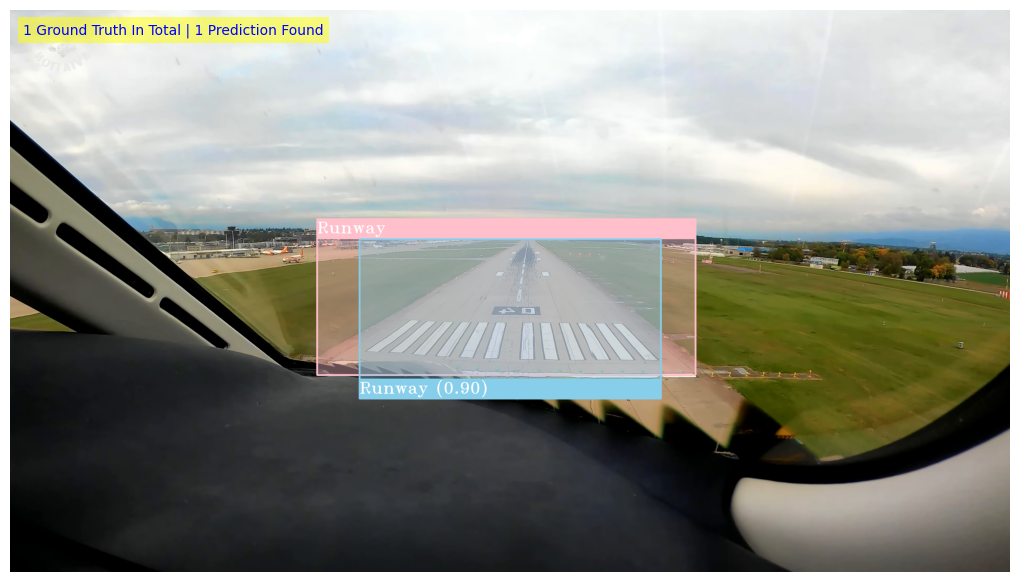

In [7]:
def draw_gt_pred(image, anns, preds):

    # 全局参数
    FONT_SCALE = 2
    FONT = cv2.FONT_HERSHEY_TRIPLEX
    LINE_WIDTH = 5
    COLOR_TEXT = (255, 255, 255)
    COLOR_GT = (255, 192, 203)  # 粉色
    COLOR_PRED = (135, 206, 235)  # 天蓝
    ALPHA = 0.4

    # 备份图像
    img = image.copy()

    # 绘制 GT bbox
    for ann in anns:

        # bbox位置
        x_left, y_top, w, h = [int(x) for x in ann['bbox']]
        x_right = x_left + w
        y_bottom = y_top + h
        label_id = ann['category_id']

        # 类别label
        label_text = id_2_name[label_id]

        # 文本 [类名称]
        text = label_text.capitalize()

        # 文字尺寸
        (w_text, h_text), _ = cv2.getTextSize(text, FONT, FONT_SCALE, 2)

        # 绘制bbox
        cv2.rectangle(
            img,
            (x_left, y_top),
            (x_right, y_bottom),
            COLOR_GT, LINE_WIDTH)
        # MASK
        overlay = img.copy()
        cv2.rectangle(
            overlay,
            (x_left, y_top),
            (x_right, y_bottom),
            COLOR_GT, -1)
        cv2.addWeighted(overlay, ALPHA, img, 1 - ALPHA, 0, img)

        # 绘制文字背景 bbox上部
        bg_x_right = x_right if w_text < w else x_left + w_text
        h_bias = 30
        # 填充
        cv2.rectangle(
            img,
            (x_left, y_top),  # 左下角
            (bg_x_right, y_top-h_text-h_bias),  # 右上角
            COLOR_GT, -1)
        # 边缘
        cv2.rectangle(
            img,
            (x_left, y_top),  # 左下角
            (bg_x_right, y_top-h_text-h_bias),  # 右上角
            COLOR_GT, LINE_WIDTH)

        # 绘制文本
        cv2.putText(
            img,
            text,
            (x_left, y_top-20),
            FONT, FONT_SCALE, COLOR_TEXT, 2)

    # 绘制 Pred bbox
    for pred in preds:

        # bbox位置
        x_left, y_top, w, h = [int(x) for x in pred['bbox']]
        x_right = x_left + w
        y_bottom = y_top + h

        # 类别label
        label_id = pred['category_id']
        label_text = id_2_name[label_id]

        # 置信度
        score = pred['score']

        # 文本 [类别+置信度]
        text = f"{label_text} ({score:.2f})".capitalize()

        # 文字尺寸
        (w_text, h_text), _ = cv2.getTextSize(text, FONT, FONT_SCALE, 2)

        # 绘制bbox
        cv2.rectangle(
            img,
            (x_left, y_top),
            (x_right, y_bottom),
            COLOR_PRED, LINE_WIDTH)
        # MASK
        overlay = img.copy()
        cv2.rectangle(
            overlay,
            (x_left, y_top),
            (x_right, y_bottom),
            COLOR_PRED, -1)
        cv2.addWeighted(overlay, ALPHA, img, 1 - ALPHA, 0, img)

        # 绘制文字背景 bbox上部
        bg_x_right = x_right if w_text < w else x_left + w_text
        h_bias = 30
        # 填充
        cv2.rectangle(
            img,
            (x_left, y_bottom),  # 左上角
            (bg_x_right, y_bottom + h_text + h_bias),  # 右下角
            COLOR_PRED, -1)
        # 边缘
        cv2.rectangle(
            img,
            (x_left, y_bottom),  # 左上角
            (bg_x_right, y_bottom + h_text + h_bias),  # 右下角
            COLOR_PRED, LINE_WIDTH)
        # 绘制文本
        cv2.putText(
            img,
            text,
            (x_left, y_bottom + h_text + 10),
            FONT, FONT_SCALE, COLOR_TEXT, 2)

    # INFO
    num_gt = len(anns)
    num_pred = len(preds)
    info = f"{num_gt} Ground {'Truth' if num_gt in [0, 1] else 'Truths'} In Total | {num_pred} {'Prediction' if num_pred in [0, 1] else 'Predictions'} Found"
    (w_text, h_text), _ = cv2.getTextSize(info, FONT, 3, 2)

    # 绘图
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(img)
    ax.text(
        50, 50, info,
        bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none'),
        color='blue', va='top', ha='left')
    ax.axis('off')
    return fig


# 在图像上绘制GT框和PRED框
fig = draw_gt_pred(image, anns, preds)
plt.tight_layout()
plt.show()